4


2023-04-12 16:55:46.348278: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 16:55:49.543200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47222 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-04-12 16:55:52.356016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


Accuracy:  0.814748201438849 Name:  10
F1 score:  0.8151312620123807 10


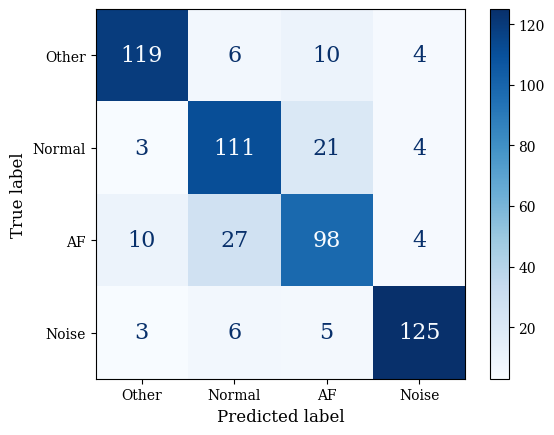

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
import time
import timeit
import h5py
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import matplotlib.pyplot as plt

from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_processing import (zero_filter, extend_ts, 
                                  random_resample, spectrogram, norm_float)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
#levinthal 
hd_file = "/scratch/thurasx/ecg_project_2/cnn_ecg_keras/physio.h5"
label_file = "/scratch/thurasx/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv"

BINARY = False
# mac 
# hd_file = "/Users/macbookpro/Documents/physio.h5"
# label_file = "/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv"
h5file =  h5py.File(hd_file, 'r')
# Open hdf5 file


# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]


# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))
labels = dict(zip(label_df.name, label_df.encoded))

with open(f"/scratch/thurasx/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/cnn_small_testing_testlabel.pcl", "rb") as f:
    test_labels = pickle.load(f)

# test_labels = list(label_df.iloc[id_train,].name) + list(label_df.iloc[id_val,].name) + list(label_df.iloc[id_test,].name)
# print(len(test_labels))
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32

# calculate image dimensions
data = fetch_h5data(h5file, [0], sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape




batch_size= batch_size
dim= dim
nperseg= spectrogram_nperseg
noverlap= spectrogram_noverlap
n_channels= 1
sequence_length= sequence_length
n_classes=n_classes
shuffle= True
data_mean = -9.01
data_std = 9.00
# Initialization
augment = False
batch_size = len(test_labels)
X = np.empty((batch_size, *dim, n_channels), dtype = float)
y = np.empty((batch_size), dtype = int)
for i, ID in enumerate(test_labels):
    # if i == 10:
    #     break
    data = extend_ts(h5file[ID]['ecgdata'][:, 0], sequence_length)
    data = np.reshape(data, (1, len(data)))

    if augment:
    
        # dropout bursts
        data = zero_filter(data, threshold = 2, depth = 10)
    
        # random resampling
        data = random_resample(data)
    
    # Generate spectrogram
    data_spectrogram = spectrogram(data, nperseg = nperseg, noverlap = noverlap)[2]
    
    # Normalize
    data_transformed = norm_float(data_spectrogram, data_mean, data_std)

    X[i,] = np.expand_dims(data_transformed, axis = 3)
    # print(X[i,].shape)
    # Assuming that the dataset names are unique (only 1 per label)
    y[i] = labels[ID]
    
if BINARY:
    n_classes = 2
    for i, elm in enumerate(y):
        if elm == 0 or elm == 1 or elm == 3:
            y[i] = 0
        elif elm == 2:
            y[i] = 1
# X = X.reshape(batch_size,570,-1)
print(n_classes)
X_test = X
y_test = keras.utils.to_categorical(y, num_classes=n_classes)


# with open("/scratch/thurasx/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/X_test.npy", "wb") as f:
#     np.save(f, X_test)

# with open("/scratch/thurasx/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/y_test.npy", "wb") as f:
#     np.save(f, y_test)

FILENAME = "10"
def custom_categorical_crossentropy(y_true, y_pred):
    # Define the weight for class 3
    weight_class_3 = 50.0

    # Calculate the normal categorical crossentropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Extract the class labels from y_true and y_pred
    true_class = tf.argmax(y_true, axis=-1)
    pred_class = tf.argmax(y_pred, axis=-1)

    # Calculate the loss mask to penalize predictions for class 3
    loss_mask = tf.cast(tf.equal(true_class, 2), dtype=tf.float32) * weight_class_3

    # Return the weighted loss
    return loss + loss_mask

model = tf.keras.models.load_model(f'/scratch/thurasx/ecg_project_2/cnn_ecg_keras/cnn_ecg_keras_tflites/keras_ecg_cnn_small_{FILENAME}.h5')



y_pre = model.predict(X_test)
y_pred = [i.argmax()for i in y_pre]
y_true = [i.argmax()for i in y_test]
labels = ['Other', 'Normal', 'AF', 'Noise']
print("Accuracy: ", accuracy_score(y_true, y_pred), "Name: ", FILENAME)
print("F1 score: ", f1_score(y_true, y_pred, average='weighted'), FILENAME)

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 16}
plt.rc('font', **font)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
cmd.plot(cmap="Blues")
plt.savefig(fname='confusion_v3.pdf', dpi=300,
                bbox_inches='tight',pad_inches=0.05)